In [1]:
from pathlib import Path
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import random

DATA_PATH = Path("../data/processed/snippets.npz")
EMBED_OUT_PATH = Path("../data/processed/autoencoder_embeddings.npz")

In [2]:
# ---------------------
# Dataset & utilities
# ---------------------

class MelodySnippetsDataset(Dataset):
    def __init__(self, intervals, indices):
        """
        intervals: np.ndarray of shape (N, L)
        indices: np.ndarray of snippet indices to use for this split
        """
        self.intervals = intervals
        self.indices = np.array(indices, dtype=int)

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        i = self.indices[idx]
        seq = self.intervals[i]  # shape (L,)
        # return as tensor of token ids
        return torch.tensor(seq, dtype=torch.long)


def load_data_and_build_vocab(data_path=DATA_PATH):
    data = np.load(data_path, allow_pickle=True)
    intervals = data["intervals"]  # (N, L)
    song_ids = data["song_ids"]
    # durations = data["durations"]  # not used yet
    midi_filenames = data.get("midi_filenames", None)

    # Map raw interval values (can be negative) to token ids [0..V-1]
    min_interval = intervals.min()
    max_interval = intervals.max()
    shifted_intervals = intervals - min_interval  # now in [0..(max-min)]

    vocab_size = int(max_interval - min_interval + 1)

    return shifted_intervals, song_ids, midi_filenames, min_interval, vocab_size


def split_by_song(song_ids, train_frac=0.7, val_frac=0.15, seed=42):
    """
    Split songs (by unique song_id) into train/val/test.
    Returns three arrays of snippet indices: train_idx, val_idx, test_idx.
    """
    rng = np.random.default_rng(seed)
    unique_songs = np.unique(song_ids)
    rng.shuffle(unique_songs)

    n_songs = len(unique_songs)
    n_train = int(train_frac * n_songs)
    n_val = int(val_frac * n_songs)

    train_songs = unique_songs[:n_train]
    val_songs = unique_songs[n_train:n_train + n_val]
    test_songs = unique_songs[n_train + n_val:]

    def idx_for(songs_subset):
        mask = np.isin(song_ids, songs_subset)
        return np.where(mask)[0]

    train_idx = idx_for(train_songs)
    val_idx = idx_for(val_songs)
    test_idx = idx_for(test_songs)

    return train_idx, val_idx, test_idx

In [3]:
# ---------------------
# Autoencoder model
# ---------------------

class MelodyAutoencoder(nn.Module):
    def __init__(self, vocab_size, embed_dim=64, hidden_dim=128, num_layers=1):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim)
        self.encoder_rnn = nn.GRU(embed_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.decoder_rnn = nn.GRU(embed_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.output_fc = nn.Linear(hidden_dim, vocab_size)

        # Learned start token for the decoder
        self.start_token = nn.Parameter(torch.zeros(1, 1, embed_dim))

    def encode(self, x):
        emb = self.embed(x)
        _, h_n = self.encoder_rnn(emb)
        return h_n[-1]  # (B, H)

    def decode(self, z, seq_len):
        """
        z: (B, H)
        seq_len: int (L)
        Decoder only gets z + a learned start vector, not the target tokens.
        """
        B = z.size(0)
        h0 = z.unsqueeze(0)              # (1, B, H)

        # Repeat a learned start embedding L times as input
        # shape: (B, L, E)
        start_emb = self.start_token.expand(B, seq_len, -1)

        out, _ = self.decoder_rnn(start_emb, h0)  # (B, L, H)
        logits = self.output_fc(out)              # (B, L, V)
        return logits

    def forward(self, x):
        z = self.encode(x)
        L = x.shape[1]
        logits = self.decode(z, L)
        return logits, z



In [4]:
# ---------------------
# Training loop
# ---------------------
def train_autoencoder(
    batch_size=64,
    num_epochs=10,
    lr=1e-3,
    device=None,
):
    intervals, song_ids, midi_filenames, min_interval, vocab_size = load_data_and_build_vocab()

    train_idx, val_idx, test_idx = split_by_song(song_ids)

    print(f"Total snippets: {intervals.shape[0]}")
    print(f"Train/Val/Test sizes: {len(train_idx)}, {len(val_idx)}, {len(test_idx)}")
    print(f"Interval vocab size: {vocab_size}, min_interval={min_interval}")

    train_ds = MelodySnippetsDataset(intervals, train_idx)
    val_ds = MelodySnippetsDataset(intervals, val_idx)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)

    model = MelodyAutoencoder(vocab_size=vocab_size, embed_dim=64, hidden_dim=128)
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    def run_epoch(loader, train=True):
        if train:
            model.train()
        else:
            model.eval()
        total_loss = 0.0
        n_tokens = 0

        for batch in loader:
            batch = batch.to(device)  # (B, L)
            optimizer.zero_grad()
            with torch.set_grad_enabled(train):
                logits, _ = model(batch)  # logits: (B, L, V)
                B, L, V = logits.shape
                loss = criterion(logits.view(B * L, V), batch.view(B * L))
                if train:
                    loss.backward()
                    optimizer.step()
            total_loss += loss.item() * B * L
            n_tokens += B * L

        return total_loss / n_tokens

    train_losses = []
    val_losses = []

    for epoch in range(1, num_epochs + 1):
        train_loss = run_epoch(train_loader, train=True)
        val_loss   = run_epoch(val_loader, train=False)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        print(f"Epoch {epoch:02d} | train_loss={train_loss:.4f} | val_loss={val_loss:.4f}")

    # After training, compute embeddings for all snippets (train+val+test)
    model.eval()
    all_embeddings = []

    full_ds = MelodySnippetsDataset(intervals, np.arange(intervals.shape[0]))
    full_loader = DataLoader(full_ds, batch_size=batch_size, shuffle=False)

    with torch.no_grad():
        for batch in full_loader:
            batch = batch.to(device)
            z = model.encode(batch)  # (B, H)
            all_embeddings.append(z.cpu().numpy())

    all_embeddings = np.vstack(all_embeddings)  # (N, H)
    print("All embeddings shape:", all_embeddings.shape)

    # Load snippet meta and save embeddings (unchanged from your version)
    snippet_meta = np.load(DATA_PATH, allow_pickle=True)
    genres = snippet_meta.get("genres", None)
    snippet_labels = snippet_meta.get("snippet_labels", None)
    snippet_start_secs = snippet_meta.get("snippet_start_secs", None)
    snippet_end_secs = snippet_meta.get("snippet_end_secs", None)

    EMBED_OUT_PATH.parent.mkdir(parents=True, exist_ok=True)
    np.savez_compressed(
        EMBED_OUT_PATH,
        embeddings=all_embeddings,
        song_ids=song_ids,
        min_interval=min_interval,
        vocab_size=vocab_size,
        midi_filenames=midi_filenames,
        genres=genres,
        snippet_labels=snippet_labels,
        snippet_start_secs=snippet_start_secs,
        snippet_end_secs=snippet_end_secs,
    )
    print(f"Saved autoencoder embeddings to {EMBED_OUT_PATH}")
    print("Test indices (for later evaluation) length:", len(test_idx))

    # ✅ Return the *trained model* plus the info dict
    info = {
        "train_idx": train_idx,
        "val_idx": val_idx,
        "test_idx": test_idx,
        "min_interval": min_interval,
        "vocab_size": vocab_size,
        "train_losses": train_losses,
        "val_losses": val_losses,
        "device": device,
    }
    return model, info


In [5]:
# ---------------------
# Retrieval using embeddings
# ---------------------

def load_embeddings(embed_path=EMBED_OUT_PATH):
    data = np.load(embed_path, allow_pickle=True)
    embeddings = data["embeddings"]   # (N, H)
    song_ids = data["song_ids"]
    midi_filenames = data.get("midi_filenames", None)
    genres = data.get("genres", None)
    snippet_labels = data.get("snippet_labels", None)
    snippet_start_secs = data.get("snippet_start_secs", None)
    snippet_end_secs = data.get("snippet_end_secs", None)
    return embeddings, song_ids, midi_filenames, genres, snippet_labels, snippet_start_secs, snippet_end_secs


def cosine_sim(a, b):
    """
    a: (N, H)
    b: (H,) or (1, H)
    returns: (N,)
    """
    a_norm = a / np.linalg.norm(a, axis=1, keepdims=True)
    b_norm = b / np.linalg.norm(b)
    return np.dot(a_norm, b_norm)


def retrieve_with_embeddings(query_idx, top_k=5):
    (embeddings,
     song_ids,
     midi_filenames,
     genres,
     snippet_labels,
     snippet_start_secs,
     snippet_end_secs) = load_embeddings()

    N, H = embeddings.shape
    if query_idx < 0 or query_idx >= N:
        raise ValueError(f"query_idx {query_idx} out of range [0, {N-1}]")

    q_emb = embeddings[query_idx]  # (H,)
    sims = cosine_sim(embeddings, q_emb)  # (N,)

    # Higher cosine similarity = more similar
    sorted_idx = np.argsort(-sims)

    q_sid = int(song_ids[query_idx])
    q_file = midi_filenames[q_sid] if midi_filenames is not None else "N/A"
    q_genre = genres[query_idx] if genres is not None else "N/A"
    q_label = snippet_labels[query_idx] if snippet_labels is not None else None
    q_start = snippet_start_secs[query_idx] if snippet_start_secs is not None else None
    q_end = snippet_end_secs[query_idx] if snippet_end_secs is not None else None

    print(f"Query snippet {query_idx}, song_id={q_sid}, genre={q_genre}")
    print(f"  file={q_file}")
    if q_label is not None:
        print(f"  label={q_label}")
    if q_start is not None and q_end is not None:
        print(f"  approx time: {q_start:.2f}s → {q_end:.2f}s")

    print(f"\nTop {top_k} neighbors by embedding cosine similarity:")
    printed = 0
    for idx in sorted_idx:
        if idx == query_idx:
            continue
        sid = int(song_ids[idx])
        fname = midi_filenames[sid] if midi_filenames is not None else "N/A"
        g = genres[idx] if genres is not None else "N/A"
        lbl = snippet_labels[idx] if snippet_labels is not None else None
        s_sec = snippet_start_secs[idx] if snippet_start_secs is not None else None
        e_sec = snippet_end_secs[idx] if snippet_end_secs is not None else None

        line = f"  idx={idx:4d}, song_id={sid}, genre={g}, file={fname}, sim={sims[idx]:.3f}"
        print(line)
        if lbl is not None:
            print(f"     label={lbl}")
        if s_sec is not None and e_sec is not None:
            print(f"     approx time: {s_sec:.2f}s → {e_sec:.2f}s")

        printed += 1
        if printed >= top_k:
            break

In [6]:
def inspect_reconstructions(model, intervals, min_interval, device, num_examples=5, seed=0):
    """
    Print original vs reconstructed interval sequences for a few random snippets.

    intervals: np.ndarray of shape (N, L)  -- *shifted* intervals used for training
    min_interval: the offset that was subtracted (to map tokens back)
    """
    model.eval()
    rng = np.random.default_rng(seed)
    N = intervals.shape[0]
    example_indices = rng.integers(low=0, high=N, size=num_examples)

    print(f"Inspecting {num_examples} random reconstructions:")
    with torch.no_grad():
        x = torch.tensor(intervals[example_indices], dtype=torch.long, device=device)
        logits, _ = model(x)               # (B, L, V)
        preds = torch.argmax(logits, dim=-1).cpu().numpy()  # (B, L)

    for i, idx in enumerate(example_indices):
        orig_tokens = intervals[idx]       # shifted
        recon_tokens = preds[i]

        # Map back to actual interval values by adding min_interval
        orig_intervals = orig_tokens + min_interval
        recon_intervals = recon_tokens + min_interval

        print(f"\nSnippet index {idx}:")
        print("  original intervals:", orig_intervals.tolist())
        print("  reconstr intervals:", recon_intervals.tolist())


In [7]:
model, info = train_autoencoder(num_epochs=500, batch_size=64, lr=1e-3)

# Use the same intervals & min_interval used in training
intervals, song_ids, midi_filenames, min_interval, vocab_size = load_data_and_build_vocab()
device = info["device"]

inspect_reconstructions(model, intervals, min_interval, device, num_examples=5)


Total snippets: 34513
Train/Val/Test sizes: 24131, 5089, 5293
Interval vocab size: 184, min_interval=-94
Using device: cuda
Epoch 01 | train_loss=3.1286 | val_loss=2.9066
Epoch 02 | train_loss=2.7062 | val_loss=2.7099
Epoch 03 | train_loss=2.5433 | val_loss=2.5739
Epoch 04 | train_loss=2.4230 | val_loss=2.4728
Epoch 05 | train_loss=2.3327 | val_loss=2.4003
Epoch 06 | train_loss=2.2614 | val_loss=2.3364
Epoch 07 | train_loss=2.2035 | val_loss=2.2895
Epoch 08 | train_loss=2.1530 | val_loss=2.2481
Epoch 09 | train_loss=2.1088 | val_loss=2.2045
Epoch 10 | train_loss=2.0691 | val_loss=2.1688
Epoch 11 | train_loss=2.0325 | val_loss=2.1319
Epoch 12 | train_loss=1.9968 | val_loss=2.1070
Epoch 13 | train_loss=1.9645 | val_loss=2.0821
Epoch 14 | train_loss=1.9320 | val_loss=2.0416
Epoch 15 | train_loss=1.9018 | val_loss=2.0169
Epoch 16 | train_loss=1.8743 | val_loss=2.0015
Epoch 17 | train_loss=1.8501 | val_loss=1.9736
Epoch 18 | train_loss=1.8222 | val_loss=1.9858
Epoch 19 | train_loss=1.8026 |

In [8]:
auto_model = model

# Save weights
AUTO_MODEL_PATH = Path("../models/autoencoder.pt")
AUTO_MODEL_PATH.parent.mkdir(parents=True, exist_ok=True)
torch.save(auto_model.state_dict(), AUTO_MODEL_PATH)
print("Saved autoencoder to", AUTO_MODEL_PATH)

Saved autoencoder to ../models/autoencoder.pt


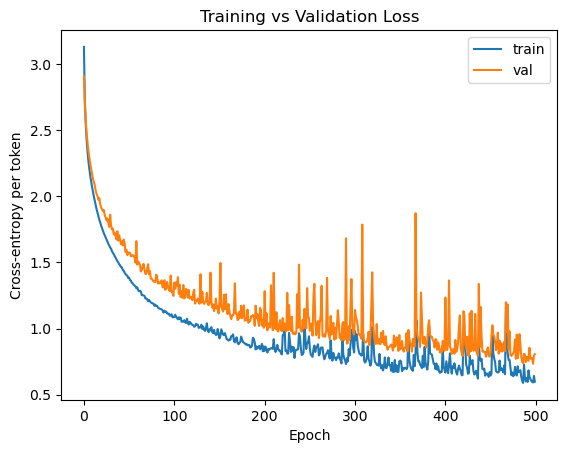

In [9]:
import matplotlib.pyplot as plt
plt.plot(info["train_losses"], label="train")
plt.plot(info["val_losses"], label="val")
plt.legend()
plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Cross-entropy per token")
plt.show()

In [10]:
from pathlib import Path
import numpy as np

EMBED_OUT_PATH = Path("../data/processed/autoencoder_embeddings.npz")

def load_embeddings_full(embed_path: Path = EMBED_OUT_PATH):
    """
    Load embeddings and metadata from the saved NPZ.
    """
    data = np.load(embed_path, allow_pickle=True)

    embeddings = data["embeddings"]   # (N, H)
    song_ids = data["song_ids"]       # (N,)
    midi_filenames = data.get("midi_filenames", None)
    genres = data.get("genres", None)
    snippet_labels = data.get("snippet_labels", None)
    snippet_start_secs = data.get("snippet_start_secs", None)
    snippet_end_secs = data.get("snippet_end_secs", None)

    return (embeddings,
            song_ids,
            midi_filenames,
            genres,
            snippet_labels,
            snippet_start_secs,
            snippet_end_secs)


In [11]:
from sklearn.decomposition import PCA

def plot_pca_snippets_by_genre(max_points: int = 5000, random_state: int = 42):
    """
    PCA projection of *snippet-level* embeddings, colored by genre.
    """
    (embeddings,
     song_ids,
     midi_filenames,
     genres,
     snippet_labels,
     snippet_start_secs,
     snippet_end_secs) = load_embeddings_full()

    N, H = embeddings.shape
    print(f"Loaded embeddings: N={N}, dim={H}")

    if genres is None:
        raise ValueError("No 'genres' array found in embeddings NPZ.")

    genres = np.asarray(genres)

    # Subsample snippets if needed
    if N > max_points:
        rng = np.random.default_rng(random_state)
        idx = rng.choice(N, size=max_points, replace=False)
        emb_sub = embeddings[idx]
        genres_sub = genres[idx]
        print(f"Subsampled to {emb_sub.shape[0]} snippets for PCA.")
    else:
        emb_sub = embeddings
        genres_sub = genres

    unique_genres = np.unique(genres_sub)
    genre_to_id = {g: i for i, g in enumerate(unique_genres)}
    genre_ids = np.array([genre_to_id[g] for g in genres_sub])

    print("Running PCA (snippets)...")
    pca = PCA(n_components=2, random_state=random_state)
    emb_2d = pca.fit_transform(emb_sub)  # (M_snippets, 2)

    print(f"Explained variance ratios: PC1={pca.explained_variance_ratio_[0]:.3f}, "
          f"PC2={pca.explained_variance_ratio_[1]:.3f}")

    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(
        emb_2d[:, 0],
        emb_2d[:, 1],
        c=genre_ids,
        s=5,
        alpha=0.7,
        cmap="tab20",
    )

    handles, _ = scatter.legend_elements(num=len(unique_genres))
    plt.legend(handles, unique_genres, title="Genre",
               bbox_to_anchor=(1.05, 1), loc="upper left")

    plt.title("PCA of snippet-level melody embeddings (colored by genre)")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.tight_layout()
    plt.show()

Loaded embeddings: N=34513, dim=128
Subsampled to 5000 snippets for PCA.
Running PCA (snippets)...
Explained variance ratios: PC1=0.117, PC2=0.068


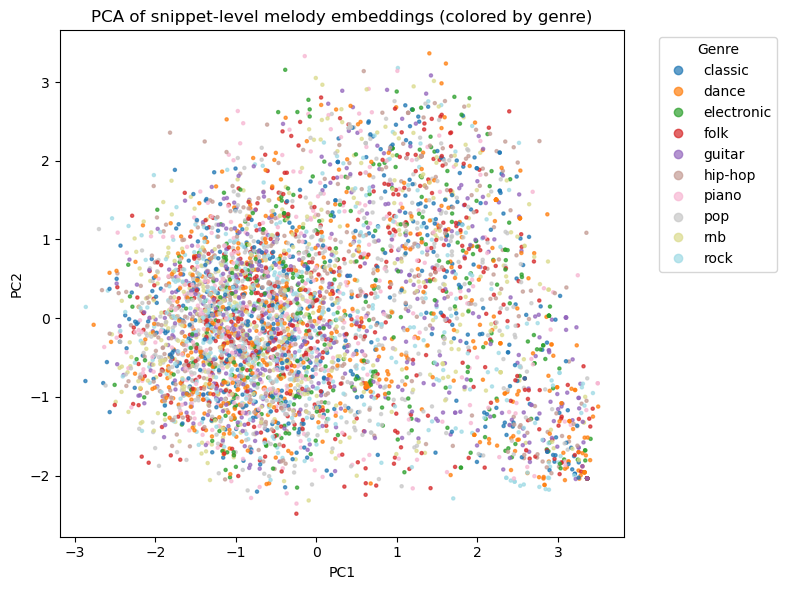

In [12]:
plot_pca_snippets_by_genre(max_points=5000)

In [19]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def plot_tsne_by_genre(max_points: int = 2000, random_state: int = 42):
    """
    Project snippet embeddings to 2D with t-SNE and color by genre.
    max_points: subsample this many snippets for speed (if N is large).
    """
    (embeddings,
     song_ids,
     midi_filenames,
     genres,
     snippet_labels,
     snippet_start_secs,
     snippet_end_secs) = load_embeddings_full()

    N, H = embeddings.shape
    print(f"Loaded embeddings: N={N}, dim={H}")

    if genres is None:
        raise ValueError("No 'genres' array found in embeddings NPZ.")

    genres = np.asarray(genres)

    # Subsample for speed if needed
    if N > max_points:
        rng = np.random.default_rng(random_state)
        idx = rng.choice(N, size=max_points, replace=False)
        emb_sub = embeddings[idx]
        genres_sub = genres[idx]
        print(f"Subsampled to {emb_sub.shape[0]} points for t-SNE.")
    else:
        idx = np.arange(N)
        emb_sub = embeddings
        genres_sub = genres

    # Map genres to integer IDs for coloring
    unique_genres = np.unique(genres_sub)
    genre_to_id = {g: i for i, g in enumerate(unique_genres)}
    genre_ids = np.array([genre_to_id[g] for g in genres_sub])

    print("Running t-SNE...")
    tsne = TSNE(
        n_components=2,
        random_state=random_state,
        perplexity=30,
        init="random",
        learning_rate="auto",
    )
    emb_2d = tsne.fit_transform(emb_sub)  # (M, 2)

    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(
        emb_2d[:, 0],
        emb_2d[:, 1],
        c=genre_ids,
        s=5,
        alpha=0.7,
        cmap="tab20",
    )

    # Legend with genre names
    handles, _ = scatter.legend_elements(num=len(unique_genres))
    plt.legend(handles, unique_genres, title="Genre", bbox_to_anchor=(1.05, 1), loc="upper left")

    plt.title("t-SNE of melody embeddings (colored by genre)")
    plt.xlabel("t-SNE 1")
    plt.ylabel("t-SNE 2")
    plt.tight_layout()
    plt.show()


Loaded embeddings: N=34513, dim=128
Subsampled to 2000 points for t-SNE.
Running t-SNE...


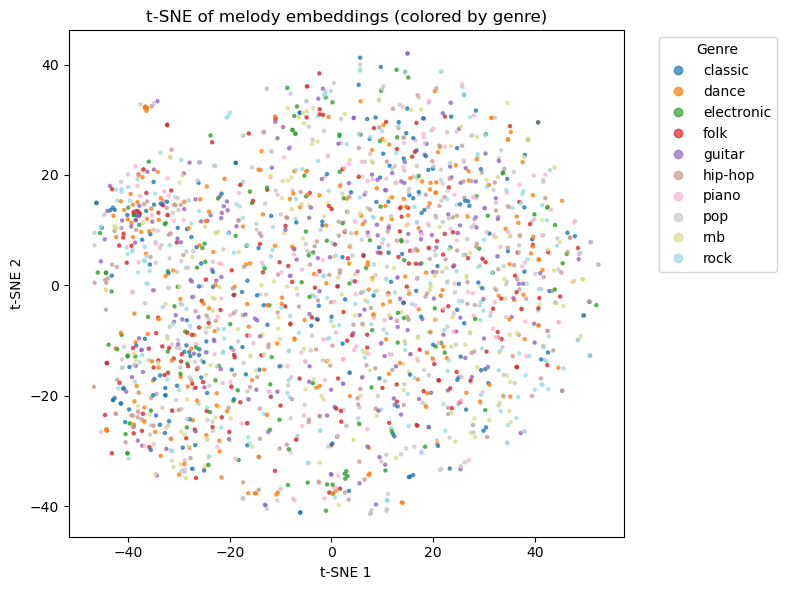

In [20]:
plot_tsne_by_genre(max_points=2000)

Patched umap.umap_.check_array for sklearn compatibility.
Loaded embeddings: N=34513, dim=128
Subsampled to 2000 points for UMAP.
Running UMAP...


/opt/conda/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


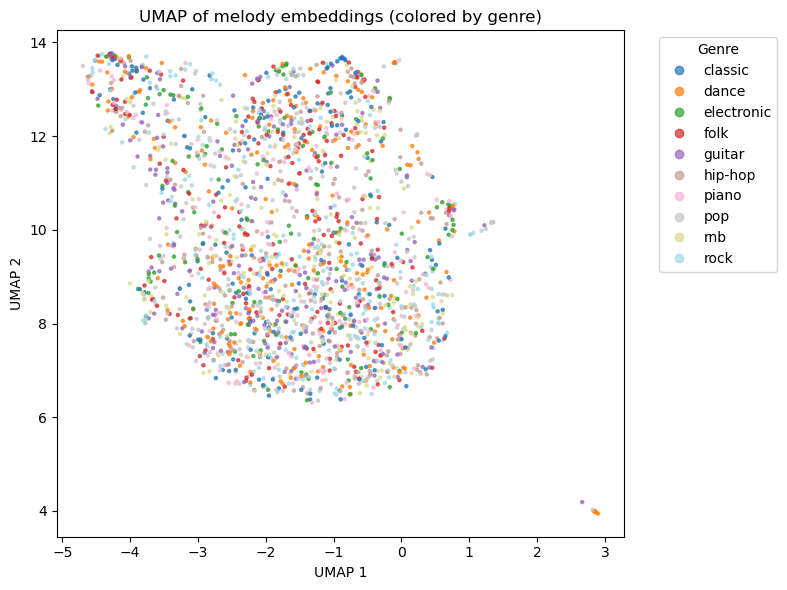

In [36]:
import umap
import matplotlib.pyplot as plt

import umap
import umap.umap_ as umap_module
from sklearn.utils import check_array as sk_check_array

def _check_array_compat(X, accept_sparse=False, dtype="numeric", order=None,
                        copy=False, force_all_finite=True, ensure_min_samples=1,
                        ensure_min_features=1, estimator=None, **kwargs):
    """
    Compatibility wrapper for sklearn.check_array, ignoring unsupported kwargs
    like `ensure_all_finite` that UMAP passes on older sklearn versions.
    """
    # Drop unknown/extra kwargs that older sklearn.check_array doesn't support
    kwargs.pop("ensure_all_finite", None)
    return sk_check_array(
        X,
        accept_sparse=accept_sparse,
        dtype=dtype,
        order=order,
        copy=copy,
        force_all_finite=force_all_finite,
        ensure_min_samples=ensure_min_samples,
        ensure_min_features=ensure_min_features,
        estimator=estimator,
    )

# Monkey-patch inside umap so its internal calls use this wrapper
umap_module.check_array = _check_array_compat

print("Patched umap.umap_.check_array for sklearn compatibility.")


def plot_umap_by_genre(max_points: int = 2000, random_state: int = 42):
    """
    Project snippet embeddings to 2D with UMAP and color by genre.
    """
    (embeddings,
     song_ids,
     midi_filenames,
     genres,
     snippet_labels,
     snippet_start_secs,
     snippet_end_secs) = load_embeddings_full()

    N, H = embeddings.shape
    print(f"Loaded embeddings: N={N}, dim={H}")

    if genres is None:
        raise ValueError("No 'genres' array found in embeddings NPZ.")

    genres = np.asarray(genres)

    # Subsample if needed
    if N > max_points:
        rng = np.random.default_rng(random_state)
        idx = rng.choice(N, size=max_points, replace=False)
        emb_sub = embeddings[idx]
        genres_sub = genres[idx]
        print(f"Subsampled to {emb_sub.shape[0]} points for UMAP.")
    else:
        idx = np.arange(N)
        emb_sub = embeddings
        genres_sub = genres

    unique_genres = np.unique(genres_sub)
    genre_to_id = {g: i for i, g in enumerate(unique_genres)}
    genre_ids = np.array([genre_to_id[g] for g in genres_sub])

    print("Running UMAP...")
    reducer = umap.UMAP(
        n_components=2,
        random_state=random_state,
        n_neighbors=15,
        min_dist=0.1,
    )
    emb_2d = reducer.fit_transform(emb_sub)  # (M, 2)

    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(
        emb_2d[:, 0],
        emb_2d[:, 1],
        c=genre_ids,
        s=5,
        alpha=0.7,
        cmap="tab20",
    )

    handles, _ = scatter.legend_elements(num=len(unique_genres))
    plt.legend(handles, unique_genres, title="Genre", bbox_to_anchor=(1.05, 1), loc="upper left")

    plt.title("UMAP of melody embeddings (colored by genre)")
    plt.xlabel("UMAP 1")
    plt.ylabel("UMAP 2")
    plt.tight_layout()
    plt.show()

plot_umap_by_genre(max_points=2000)

In [37]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import umap  # pip install umap-learn

# Path to your saved embeddings
EMBED_OUT_PATH = Path("../data/processed/autoencoder_embeddings.npz")


# -----------------------------
# 1) Load embeddings + metadata
# -----------------------------
def load_embeddings_full(embed_path: Path = EMBED_OUT_PATH):
    """
    Load embeddings and metadata from the saved NPZ.
    Assumes you saved:
      embeddings, song_ids, midi_filenames, genres,
      snippet_labels, snippet_start_secs, snippet_end_secs
    """
    data = np.load(embed_path, allow_pickle=True)

    embeddings = data["embeddings"]   # (N_snippets, H)
    song_ids = data["song_ids"]       # (N_snippets,)
    midi_filenames = data.get("midi_filenames", None)
    genres = data.get("genres", None)  # (N_snippets,) snippet-level genres (strings)
    snippet_labels = data.get("snippet_labels", None)
    snippet_start_secs = data.get("snippet_start_secs", None)
    snippet_end_secs = data.get("snippet_end_secs", None)

    return (embeddings,
            song_ids,
            midi_filenames,
            genres,
            snippet_labels,
            snippet_start_secs,
            snippet_end_secs)


# --------------------------------------------
# 2) Aggregate embeddings & genres per *song*
# --------------------------------------------
def aggregate_embeddings_by_song():
    """
    Returns:
        song_embs      : (N_songs, H)    mean embedding per song_id
        song_genres    : (N_songs,)      majority genre per song
        song_names     : (N_songs,)      midi filename per song_id
        unique_song_ids: (N_songs,)      the actual song_id values
    """
    (embeddings,
     song_ids,
     midi_filenames,
     genres,
     snippet_labels,
     snippet_start_secs,
     snippet_end_secs) = load_embeddings_full()

    if midi_filenames is None:
        raise ValueError("midi_filenames not found in NPZ.")
    if genres is None:
        raise ValueError("genres not found in NPZ (needed for coloring).")

    embeddings = np.asarray(embeddings)
    song_ids = np.asarray(song_ids)
    genres = np.asarray(genres)

    unique_songs = np.unique(song_ids)
    song_embs = []
    song_genres = []
    song_names = []

    for sid in unique_songs:
        mask = (song_ids == sid)
        e = embeddings[mask]     # all snippet embeddings for this song
        g = genres[mask]         # all snippet genres for this song

        # Mean embedding over all snippets
        song_embs.append(e.mean(axis=0))

        # Majority genre among this song's snippets
        unique_g, counts = np.unique(g, return_counts=True)
        majority_genre = unique_g[np.argmax(counts)]
        song_genres.append(majority_genre)

        # Filename for this song_id
        name = midi_filenames[sid] if midi_filenames is not None else f"song_{sid}"
        song_names.append(name)

    song_embs = np.vstack(song_embs)             # (N_songs, H)
    song_genres = np.array(song_genres)          # (N_songs,)
    song_names = np.array(song_names)            # (N_songs,)

    return song_embs, song_genres, song_names, unique_songs


# ------------------------------------
# 3) t-SNE on *songs*, colored by genre
# ------------------------------------
def plot_tsne_songs_by_genre(max_songs: int = 1000, random_state: int = 42):
    """
    t-SNE projection of *song-level* embeddings, colored by majority genre.
    """
    song_embs, song_genres, song_names, song_ids = aggregate_embeddings_by_song()
    N_songs, H = song_embs.shape
    print(f"Aggregated {N_songs} songs, embedding dim={H}")

    # Subsample songs if needed
    if N_songs > max_songs:
        rng = np.random.default_rng(random_state)
        idx = rng.choice(N_songs, size=max_songs, replace=False)
        emb_sub = song_embs[idx]
        genres_sub = song_genres[idx]
        names_sub = song_names[idx]
        print(f"Subsampled to {emb_sub.shape[0]} songs for t-SNE.")
    else:
        emb_sub = song_embs
        genres_sub = song_genres
        names_sub = song_names

    # Map genres → integer IDs
    unique_genres = np.unique(genres_sub)
    genre_to_id = {g: i for i, g in enumerate(unique_genres)}
    genre_ids = np.array([genre_to_id[g] for g in genres_sub])

    print("Running t-SNE (songs)...")
    tsne = TSNE(
        n_components=2,
        random_state=random_state,
        perplexity=30,
        init="random",
        learning_rate="auto",
    )
    emb_2d = tsne.fit_transform(emb_sub)  # (M_songs, 2)

    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(
        emb_2d[:, 0],
        emb_2d[:, 1],
        c=genre_ids,
        s=20,
        alpha=0.8,
        cmap="tab20",
    )

    # Legend
    handles, _ = scatter.legend_elements(num=len(unique_genres))
    plt.legend(handles, unique_genres, title="Genre", bbox_to_anchor=(1.05, 1), loc="upper left")

    plt.title("t-SNE of song-level melody embeddings (colored by genre)")
    plt.xlabel("t-SNE 1")
    plt.ylabel("t-SNE 2")
    plt.tight_layout()
    plt.show()


# ------------------------------------
# 4) UMAP on *songs*, colored by genre
# ------------------------------------
def plot_umap_songs_by_genre(max_songs: int = 1000, random_state: int = 42):
    """
    UMAP projection of *song-level* embeddings, colored by majority genre.
    """
    song_embs, song_genres, song_names, song_ids = aggregate_embeddings_by_song()
    N_songs, H = song_embs.shape
    print(f"Aggregated {N_songs} songs, embedding dim={H}")

    if N_songs > max_songs:
        rng = np.random.default_rng(random_state)
        idx = rng.choice(N_songs, size=max_songs, replace=False)
        emb_sub = song_embs[idx]
        genres_sub = song_genres[idx]
        names_sub = song_names[idx]
        print(f"Subsampled to {emb_sub.shape[0]} songs for UMAP.")
    else:
        emb_sub = song_embs
        genres_sub = song_genres
        names_sub = song_names

    unique_genres = np.unique(genres_sub)
    genre_to_id = {g: i for i, g in enumerate(unique_genres)}
    genre_ids = np.array([genre_to_id[g] for g in genres_sub])

    print("Running UMAP (songs)...")
    reducer = umap.UMAP(
        n_components=2,
        random_state=random_state,
        n_neighbors=15,
        min_dist=0.1,
    )
    emb_2d = reducer.fit_transform(emb_sub)  # (M_songs, 2)

    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(
        emb_2d[:, 0],
        emb_2d[:, 1],
        c=genre_ids,
        s=20,
        alpha=0.8,
        cmap="tab20",
    )

    handles, _ = scatter.legend_elements(num=len(unique_genres))
    plt.legend(handles, unique_genres, title="Genre", bbox_to_anchor=(1.05, 1), loc="upper left")

    plt.title("UMAP of song-level melody embeddings (colored by genre)")
    plt.xlabel("UMAP 1")
    plt.ylabel("UMAP 2")
    plt.tight_layout()
    plt.show()


Aggregated 912 songs, embedding dim=128
Subsampled to 800 songs for t-SNE.
Running t-SNE (songs)...


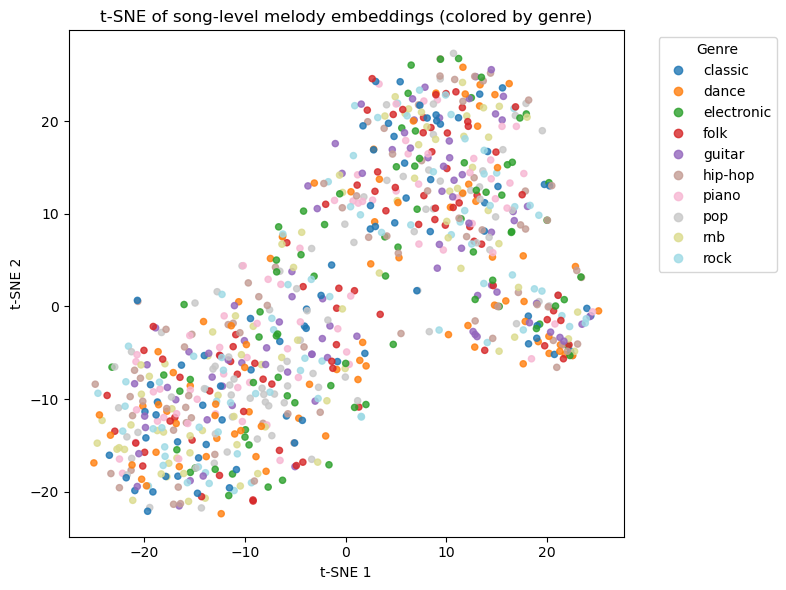

Aggregated 912 songs, embedding dim=128
Subsampled to 800 songs for UMAP.
Running UMAP (songs)...


/opt/conda/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


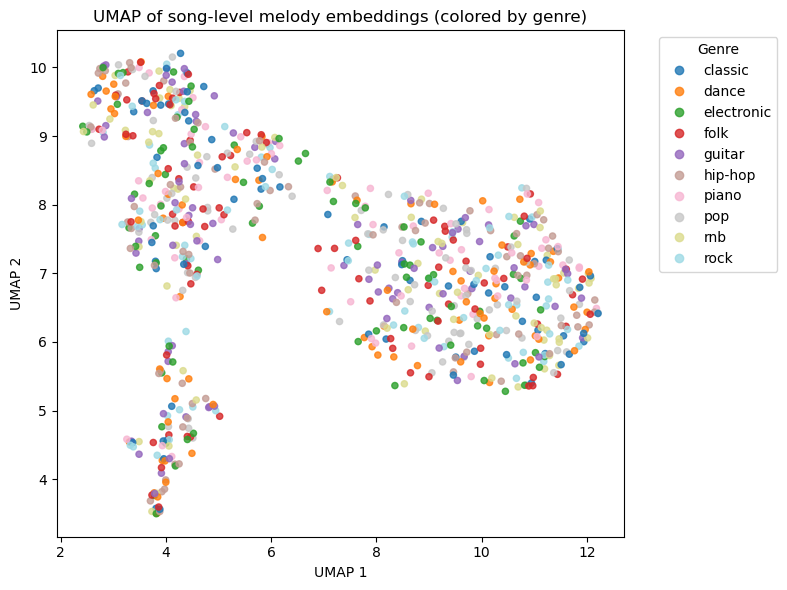

In [38]:
# t-SNE view of songs
plot_tsne_songs_by_genre(max_songs=800)

# UMAP view of songs
plot_umap_songs_by_genre(max_songs=800)

In [25]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

def plot_pca_songs_by_genre(max_songs: int = 1000, random_state: int = 42):
    """
    PCA projection of *song-level* embeddings (mean over snippets),
    colored by majority genre.
    """
    song_embs, song_genres, song_names, song_ids = aggregate_embeddings_by_song()
    N_songs, H = song_embs.shape
    print(f"Aggregated {N_songs} songs, embedding dim={H}")

    # Subsample songs if needed
    if N_songs > max_songs:
        rng = np.random.default_rng(random_state)
        idx = rng.choice(N_songs, size=max_songs, replace=False)
        emb_sub = song_embs[idx]
        genres_sub = song_genres[idx]
        names_sub = song_names[idx]
        print(f"Subsampled to {emb_sub.shape[0]} songs for PCA.")
    else:
        emb_sub = song_embs
        genres_sub = song_genres
        names_sub = song_names

    # Map genres → integer IDs
    unique_genres = np.unique(genres_sub)
    genre_to_id = {g: i for i, g in enumerate(unique_genres)}
    genre_ids = np.array([genre_to_id[g] for g in genres_sub])

    print("Running PCA (songs)...")
    pca = PCA(n_components=2, random_state=random_state)
    emb_2d = pca.fit_transform(emb_sub)  # (M_songs, 2)

    print(f"Explained variance ratios: PC1={pca.explained_variance_ratio_[0]:.3f}, "
          f"PC2={pca.explained_variance_ratio_[1]:.3f}")

    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(
        emb_2d[:, 0],
        emb_2d[:, 1],
        c=genre_ids,
        s=20,
        alpha=0.8,
        cmap="tab20",
    )

    handles, _ = scatter.legend_elements(num=len(unique_genres))
    plt.legend(handles, unique_genres, title="Genre",
               bbox_to_anchor=(1.05, 1), loc="upper left")

    plt.title("PCA of song-level melody embeddings (colored by genre)")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.tight_layout()
    plt.show()


Aggregated 912 songs, embedding dim=128
Running PCA (songs)...
Explained variance ratios: PC1=0.280, PC2=0.160


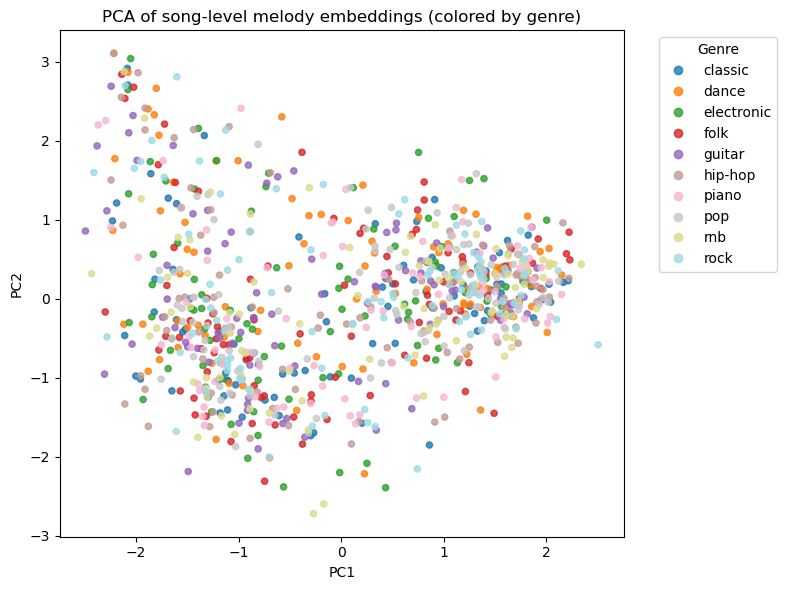

In [26]:
plot_pca_songs_by_genre(max_songs=1000)

In [27]:
from pathlib import Path
import numpy as np

DATA_PATH = Path("../data/processed/snippets.npz")

def load_snippets_for_stats(data_path: Path = DATA_PATH):
    """
    Load raw snippet data (intervals, durations, song_ids)
    for computing musical statistics.
    """
    data = np.load(data_path, allow_pickle=True)
    intervals = data["intervals"]    # (N_snips, L)
    durations = data["durations"]    # (N_snips, L)
    song_ids  = data["song_ids"]     # (N_snips,)
    return intervals, durations, song_ids


In [28]:
def compute_song_musical_features():
    """
    Compute aggregate musical statistics per song.

    Returns:
        song_feature_matrix: (N_songs, F)
        feature_names      : list of length F
        unique_song_ids    : (N_songs,)
    """
    intervals, durations, snip_song_ids = load_snippets_for_stats()
    snip_song_ids = np.asarray(snip_song_ids)

    unique_song_ids = np.unique(snip_song_ids)

    feature_names = [
        "mean_abs_interval",
        "std_interval",
        "frac_repeated",
        "frac_up",
        "frac_down",
        "mean_duration",
        "std_duration",
        "mean_melodic_range",
    ]

    song_features = []

    for sid in unique_song_ids:
        mask = (snip_song_ids == sid)

        song_int = intervals[mask]   # (n_snip_song, L)
        song_dur = durations[mask]   # (n_snip_song, L)

        flat_int = song_int.reshape(-1)
        flat_dur = song_dur.reshape(-1)

        # Filter out any padding if you ever add it (not strictly needed now)
        # Example: if you had a special PAD token value
        # flat_int = flat_int[flat_int != PAD_VALUE]

        # Basic interval stats
        mean_abs_interval = np.mean(np.abs(flat_int))
        std_interval      = np.std(flat_int)

        total_steps = len(flat_int)
        if total_steps == 0:
            # Degenerate fallback – shouldn't happen
            mean_abs_interval = 0.0
            std_interval = 0.0
            frac_repeated = 0.0
            frac_up = 0.0
            frac_down = 0.0
        else:
            frac_repeated = np.mean(flat_int == 0)
            frac_up       = np.mean(flat_int > 0)
            frac_down     = np.mean(flat_int < 0)

        # Duration stats
        mean_duration = np.mean(flat_dur)
        std_duration  = np.std(flat_dur)

        # Approx melodic range: for each snippet, cumulative sum of intervals
        # (start at 0), range = max - min; then average over snippets.
        ranges = []
        for seq in song_int:
            if len(seq) == 0:
                continue
            cum = np.cumsum(np.concatenate([[0], seq]))
            ranges.append(cum.max() - cum.min())
        if ranges:
            mean_melodic_range = float(np.mean(ranges))
        else:
            mean_melodic_range = 0.0

        song_features.append([
            mean_abs_interval,
            std_interval,
            frac_repeated,
            frac_up,
            frac_down,
            mean_duration,
            std_duration,
            mean_melodic_range,
        ])

    song_feature_matrix = np.array(song_features, dtype=float)  # (N_songs, F)
    return song_feature_matrix, feature_names, unique_song_ids


In [29]:
from sklearn.decomposition import PCA

def analyze_pca_musical_correlations(num_components: int = 5):
    """
    1. Aggregate song-level embeddings.
    2. Run PCA on them.
    3. Compute musical features per song.
    4. Print Pearson correlation between each PC and each musical feature.
    """
    # Song-level embeddings & IDs
    song_embs, song_genres, song_names, song_ids_embed = aggregate_embeddings_by_song()
    N_songs, H = song_embs.shape
    print(f"Song-level embeddings: {N_songs} songs, dim={H}")

    # Musical features per song
    song_feat_matrix, feat_names, song_ids_feat = compute_song_musical_features()
    print(f"Computed musical features for {song_feat_matrix.shape[0]} songs, "
          f"{song_feat_matrix.shape[1]} features.")

    # Align songs between embeddings and features (should match, but we enforce)
    # We'll assume both are the same set; just in case, we align using song_ids.
    id_to_feat_idx = {sid: i for i, sid in enumerate(song_ids_feat)}
    common_indices_embed = []
    common_indices_feat = []

    for i, sid in enumerate(song_ids_embed):
        if sid in id_to_feat_idx:
            common_indices_embed.append(i)
            common_indices_feat.append(id_to_feat_idx[sid])

    common_indices_embed = np.array(common_indices_embed, dtype=int)
    common_indices_feat = np.array(common_indices_feat, dtype=int)

    song_embs_aligned = song_embs[common_indices_embed]
    song_feats_aligned = song_feat_matrix[common_indices_feat]

    print(f"Aligned {song_embs_aligned.shape[0]} songs between embeddings and features.")

    # PCA on song embeddings
    pca = PCA(n_components=num_components, random_state=42)
    pcs = pca.fit_transform(song_embs_aligned)  # (N_songs_aligned, num_components)

    print("Explained variance ratios for PCs:")
    for i, r in enumerate(pca.explained_variance_ratio_):
        print(f"  PC{i+1}: {r:.4f}")

    # Correlations
    print("\nPearson correlations between PCs and musical features:")
    # header
    header = "Feature".ljust(20)
    for c in range(num_components):
        header += f" PC{c+1:>3}"
    print(header)
    print("-" * len(header))

    for f_idx, fname in enumerate(feat_names):
        row = fname.ljust(20)
        feat_vec = song_feats_aligned[:, f_idx]
        # standardize feature (optional, not needed for corr but nice)
        feat_mean = feat_vec.mean()
        feat_std = feat_vec.std() if feat_vec.std() > 1e-8 else 1.0
        feat_z = (feat_vec - feat_mean) / feat_std

        for c in range(num_components):
            pc_vec = pcs[:, c]
            # corrcoef returns 2x2; off-diagonal is correlation
            corr = np.corrcoef(pc_vec, feat_z)[0, 1]
            row += f" {corr:+.2f}"
        print(row)


In [30]:
analyze_pca_musical_correlations(num_components=5)

Song-level embeddings: 912 songs, dim=128
Computed musical features for 912 songs, 8 features.
Aligned 912 songs between embeddings and features.
Explained variance ratios for PCs:
  PC1: 0.2801
  PC2: 0.1600
  PC3: 0.0755
  PC4: 0.0637
  PC5: 0.0524

Pearson correlations between PCs and musical features:
Feature              PC  1 PC  2 PC  3 PC  4 PC  5
--------------------------------------------------
mean_abs_interval    +0.89 +0.13 -0.16 -0.21 -0.17
std_interval         +0.86 +0.18 -0.19 -0.22 -0.22
frac_repeated        -0.72 +0.63 +0.01 -0.03 -0.07
frac_up              +0.71 -0.52 -0.00 +0.08 +0.07
frac_down            +0.62 -0.65 -0.02 -0.02 +0.05
mean_duration        +0.40 -0.06 -0.10 +0.01 -0.10
std_duration         +0.32 +0.02 -0.10 -0.07 -0.09
mean_melodic_range   +0.86 +0.10 -0.19 -0.23 -0.25


In [31]:
from sklearn.decomposition import PCA
import numpy as np

def compute_song_pcs(num_components: int = 5):
    """
    Returns:
        pcs          : (N_songs, num_components) PCA coords
        pca          : fitted PCA object
        song_embs    : (N_songs, H)
        song_genres  : (N_songs,)
        song_names   : (N_songs,)
        song_ids     : (N_songs,)
    """
    song_embs, song_genres, song_names, song_ids = aggregate_embeddings_by_song()
    pca = PCA(n_components=num_components, random_state=42)
    pcs = pca.fit_transform(song_embs)
    print("Explained variance ratios:", pca.explained_variance_ratio_)
    return pcs, pca, song_embs, song_genres, song_names, song_ids


In [32]:
import matplotlib.pyplot as plt

def plot_pc1_pc2_with_titles(max_labels_per_side: int = 5):
    """
    Scatter PC1 vs PC2 (song-level), colored by genre,
    and annotate songs with extreme PC1/PC2 values.
    """
    pcs, pca, song_embs, song_genres, song_names, song_ids = compute_song_pcs(num_components=5)
    pc1 = pcs[:, 0]
    pc2 = pcs[:, 1]

    # Map genres to integers for colors
    unique_genres = np.unique(song_genres)
    genre_to_id = {g: i for i, g in enumerate(unique_genres)}
    genre_ids = np.array([genre_to_id[g] for g in song_genres])

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(pc1, pc2, c=genre_ids, s=20, alpha=0.8, cmap="tab20")

    handles, _ = scatter.legend_elements(num=len(unique_genres))
    plt.legend(handles, unique_genres, title="Genre",
               bbox_to_anchor=(1.05, 1), loc="upper left")

    plt.title("PC1 vs PC2 (song-level) with extreme songs labeled")
    plt.xlabel("PC1")
    plt.ylabel("PC2")

    # ---- annotate extremes ----
    # indices of largest/smallest PC1 and PC2
    idx_pc1_sorted = np.argsort(pc1)
    idx_pc2_sorted = np.argsort(pc2)

    extremes = set()
    extremes.update(idx_pc1_sorted[:max_labels_per_side])
    extremes.update(idx_pc1_sorted[-max_labels_per_side:])
    extremes.update(idx_pc2_sorted[:max_labels_per_side])
    extremes.update(idx_pc2_sorted[-max_labels_per_side:])

    for i in extremes:
        x, y = pc1[i], pc2[i]
        name = song_names[i]
        plt.annotate(
            name,
            (x, y),
            textcoords="offset points",
            xytext=(5, 3),
            fontsize=7,
            alpha=0.9,
        )

    plt.tight_layout()
    plt.show()


Explained variance ratios: [0.2801396  0.15995519 0.07549617 0.06374089 0.05235549]


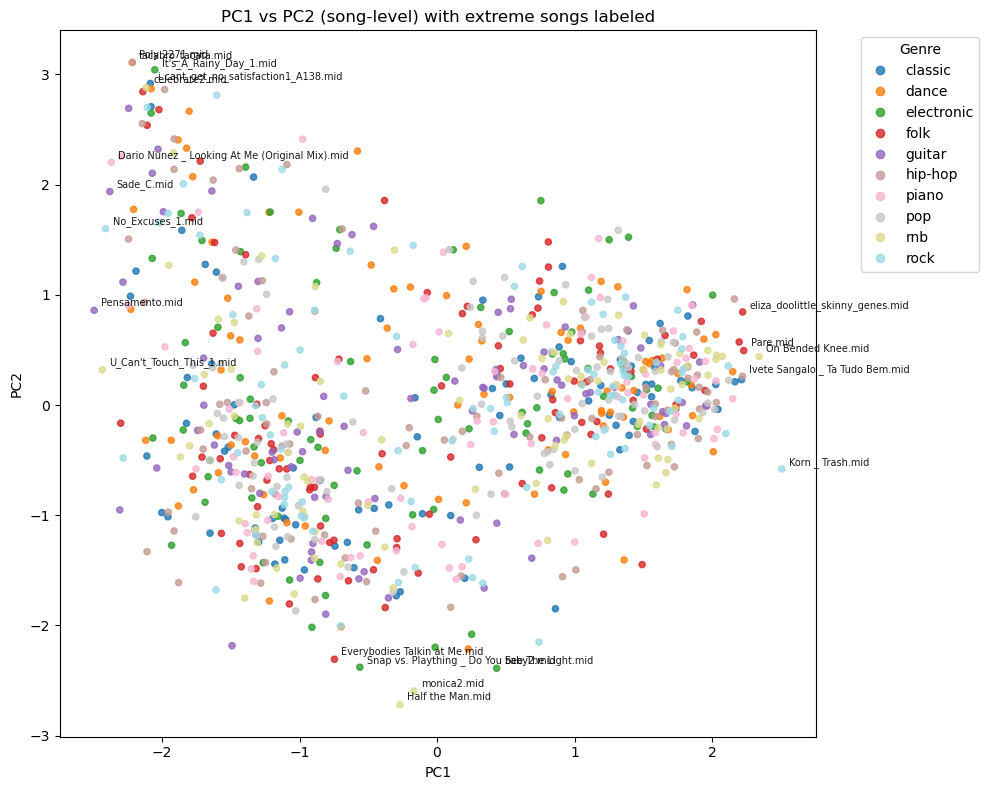

In [33]:
plot_pc1_pc2_with_titles(max_labels_per_side=5)

In [42]:
retrieve_with_embeddings(query_idx=201, top_k=5)

Query snippet 201, song_id=4, genre=classic
  file=Axel_F_1.mid
  label=classic_Axel_F_1_idx000000_to000032_t0000.00s_to0027.26s
  approx time: 0.00s → 27.26s

Top 5 neighbors by embedding cosine similarity:
  idx= 204, song_id=4, genre=classic, file=Axel_F_1.mid, sim=1.000
     label=classic_Axel_F_1_idx000048_to000080_t0040.90s_to0068.16s
     approx time: 40.90s → 68.16s
  idx= 207, song_id=4, genre=classic, file=Axel_F_1.mid, sim=0.785
     label=classic_Axel_F_1_idx000096_to000128_t0081.79s_to0121.64s
     approx time: 81.79s → 121.64s
  idx=30795, song_id=811, genre=rnb, file=rockwell.mid, sim=0.666
     label=rnb_rockwell_idx000000_to000032_t0000.00s_to0063.23s
     approx time: 0.00s → 63.23s
  idx=19371, song_id=532, genre=hip-hop, file=fergie_clumsy.mid, sim=0.660
     label=hip-hop_fergie_clumsy_idx000064_to000096_t0060.29s_to0086.03s
     approx time: 60.29s → 86.03s
  idx=18813, song_id=514, genre=hip-hop, file=Simarik.mid, sim=0.653
     label=hip-hop_Simarik_idx000000_to